<a href="_index.ipynb">&larr; LTF-Index </a>&loz;
<a href="../../README.md"> &uarr; TOC &uarr; </a>
<img src='../_img/icon.svg' align='right' width='10%'></img>

# Eigenschaften von zeitdiskreten Filtern

Mit diesem Notebook können Sie sich schnell die folgenden Eigenschaften eines zeitdiskreten Filters anzeigen lassen:

* Impulsantwort
* Betragsgang
* Phasengang
* Gruppenlaufzeit
* Pol-Nullstellen-Diagramm

In [2]:
import os, sys
module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
    
%matplotlib inline
import matplotlib.pyplot as plt
figsize = {"figsize":(13,6)}
import numpy as np
np.set_printoptions(precision=3)
import scipy.signal as sig

import dsp_fpga_lib as dsp
#plt.rcParams.update(dsp.mpl_rc) # define plot properties 

### Definition des Filters über seine Koeffizienten
In der nächsten Codezelle definieren wir das Filter über seine Koeffizienten `b, a`. Bei FIR-Filtern sind die Koeffizienten identisch zur Impulsantwort (warum?). Durch die Angabe der Abtastfrequenz `f_S` kann der Frequenzgang etc. über der absoluten Frequenz aufgetragen werden. 

In [3]:
f_S = 200
b = np.ones(16); a = 1 # MA-filter, N = 5
#b = [1, 0]; a = [1, +0.5] # lossy integrator
#-------- IIR - Filter Design mit sig.iirdesign() ------------------
Fp = 0.2 # Eckfrequenz Passband bezogen auf f_S/2
Fs = 0.3 # Eckfrequenz Stopband bezogen auf f_S/2
Apass = 1  # max. Ripple im Passband in dB
Astop = 40 # min. Dämpfung im Stopband in dB
fil_type = 'ellip' # Filterdesign, eins von 'bessel', 'butter', cheby1', 'cheby2', 'ellip'
b,a = sig.iirdesign(Fp, Fs, Apass, Astop, ftype=fil_type)

## Impulsantwort des Filters
Zur Darstellung der Impulsantwort wird die Funktion `impz(b,a,N) ` aus der `dsp_fpga_lib` verwendet. `N` ist ein optionaler Parameter, der die Anzahl der darzustellenden Impulse angibt. Wie können Sie die Impulsantwort über der Zeit $t$ anstatt über dem Index $n$ plotten?

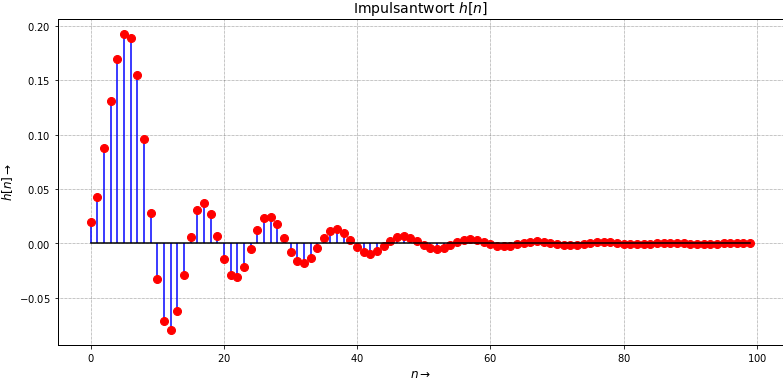

In [4]:
fig1, ax1 = plt.subplots(**figsize)
h, n = dsp.impz(b,a) # calculate impulse response from coefficients
ax1.stem(n, h, 'b-', 'ro', 'k', use_line_collection=True) # plot h[n]
ax1.set_xlabel(r'$n \rightarrow$'); plt.ylabel(r'$h[n] \rightarrow$')
ax1.set_title(r'Impulsantwort $h[n]$');

## Betragsfrequenzgang
Der Betragsfrequenzgang wird mit der Funktion `sig.freqz(b,a,whole)` bestimmt. Für `whole=True` wird das Betragsspektrum zwischen $0 ... f_S$ bestimmt an 2048 Punkten.

Zurückgegeben wird der komplexwertige Frequengang `H` bei den normalisierten Kreisfrequenzen `W`, 
dargestellt wird der Betrag $|H(f)$|.

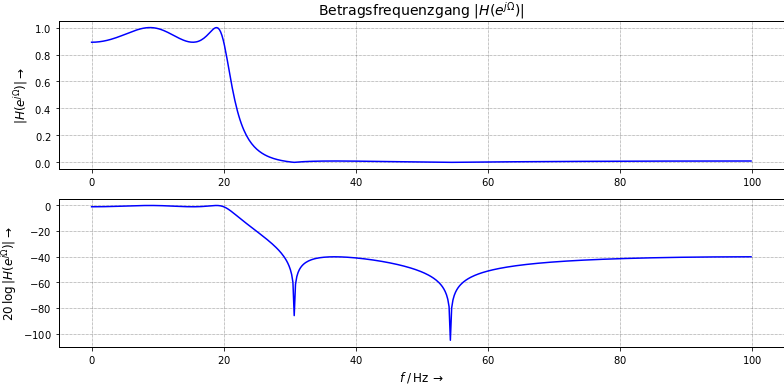

In [5]:
fig, [ax1,ax2] = plt.subplots(2,**figsize)
[W, H] = sig.freqz(b, a, whole=False);
f = f_S * W  / (2 * np.pi)
ax1.plot(f, np.abs(H), 'b')
ax1.set_ylabel(r'$|H(e^{j \Omega})| \rightarrow$')
ax1.set_title(r'Betragsfrequenzgang $|H(e^{j \Omega})|$')
#
ax2.plot(f, 20*np.log10(np.abs(H)), 'b')
ax2.set_ylabel(r'$20 \,\log \,|H(e^{j \Omega})| \rightarrow$')
ax2.set_xlabel(r'$f \; \mathrm{/\,Hz} \, \rightarrow$');

## Phasenfrequenzgang
Der Phasenfrequenzgang wird ebenfalls mit der Funktion `sig.freqz(b,a,whole)` bestimmt, hier wird die Phase des komplexwertige Frequengangs $\angle H(f)$ dargestellt und zwar "unwrapped", d.h. Python versucht die Begrenzung der Darstellung auf $\pm \pi$ aufzuheben. Entfernen Sie die "unwrap" Anweisung und vergleichen Sie die Ergebnisse.

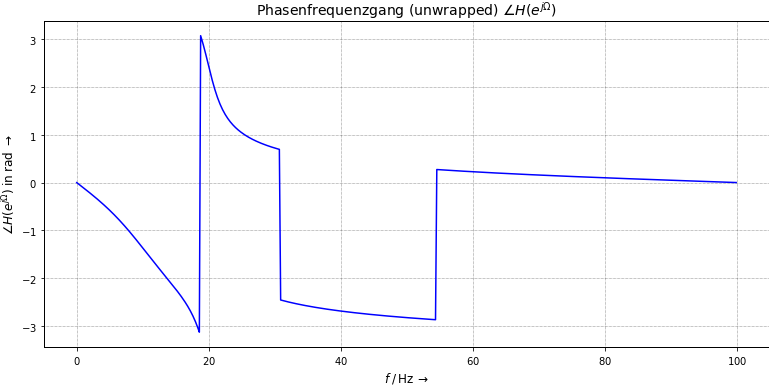

In [9]:
fig, ax = plt.subplots(**figsize)
[W, H] = sig.freqz(b, a, whole=False);
f = f_S * W  / (2 * np.pi)
#ax.plot(f,np.unwrap(np.angle(H)), 'b')
ax.plot(f,np.angle(H), 'b')
ax.set_ylabel(r'$\angle H(e^{j \Omega}) \mathrm{\;in\;rad\;} \rightarrow$')
ax.set_xlabel(r'$f \; \mathrm{/\,Hz} \, \rightarrow$')
ax.set_title(r'Phasenfrequenzgang (unwrapped) $\angle H(e^{j \Omega})$');

## Gruppenlaufzeit
Die Gruppenlaufzeit wird der Funktion `sig.freqz(b,a,whole)` bestimmt. Der dargestellte Ausschnitt der y-Achse wird hier mit `set_ylim` manuell etwas vergrößert. Was passiert bei einem linearphasigen Filter, wenn Sie diese Anweisung auskommentieren?

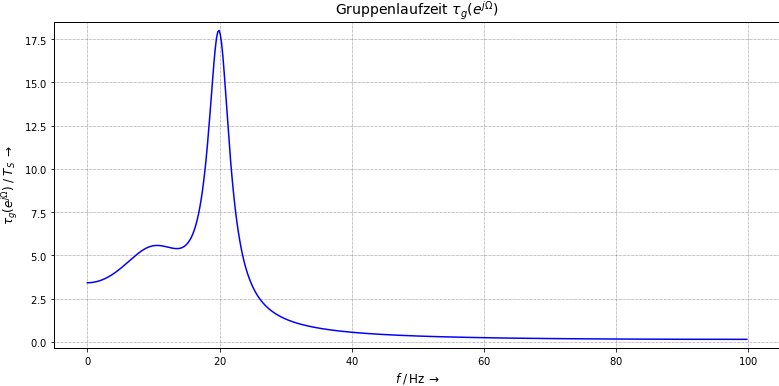

In [7]:
fig, ax = plt.subplots(**figsize)
W, tau_g = sig.group_delay((b, a));
f = f_S * W  / (2 * np.pi)
ax.plot(f, tau_g, 'b')
ax.set_ylabel(r'$\tau_g(e^{j \Omega}) \;/\; T_S \;\rightarrow$')
ax.set_xlabel(r'$f \; \mathrm{/\,Hz} \, \rightarrow$')
ax.set_ylim([min(tau_g)-0.5, max(tau_g)+0.5])
ax.set_title(r'Gruppenlaufzeit $\tau_g(e^{j \Omega})$');

## Pol- und Nullstellendiagramm
Das Pol-/Nullstellendiagramm des Systems wird `dsp.zplane(b,a)` gezeichnet. Zusätzlich werden hier Pole und Nullstellen aus den Koeffizienten bestimmt mit der `np.roots()` Funktion.

Nullstellen: [ 0.571+0.821j  0.571-0.821j -0.135+0.991j -0.135-0.991j]
Polstellen:  [0.762+0.55j  0.762-0.55j  0.754+0.244j 0.754-0.244j]



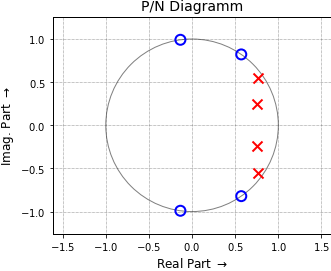

In [8]:
fig3, ax3 = plt.subplots(figsize=(5,4))
ax3.set_xlabel(r'Real Part $\rightarrow$'); ax3.set_ylabel(r'Imag. Part $\rightarrow$')
ax3.set_title('P/N Diagramm')
dsp.zplane(b,a, plt_ax=ax3);
print("Nullstellen: {0}".format(np.roots(b)))
if type(a) in {list, np.ndarray} and len(a) > 1:
    print("Polstellen:  {0}\n".format(np.roots(a)))

***
### Copyright

(c) 2016 - 2021 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp.

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing - Vorlesungsunterlagen mit Simulationsbeispielen, 2020*.